<a href="https://colab.research.google.com/github/yannidd/ai-society-lstm-lecture/blob/master/extra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up libraries

In [1]:
# Select TensorFlow 2.
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%matplotlib inline

TensorFlow 2.x selected.


In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle

from urllib.request import urlretrieve
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# Increase matplotlib font size.
font = {'size': 14}
matplotlib.rc('font', **font)

## Data

### Load

In [4]:
url = 'https://raw.githubusercontent.com/yannidd/ai-society-lstm-lecture/master/data_extra.pkl'
filename = 'data_extra.pkl'
urlretrieve (url, filename)

with open(filename, 'rb') as file:
    x, y = pickle.load(file)

print(f'x length: {len(x)}\n'
      f'y length: {len(y)}')

x length: 1103
y length: 1103


In [5]:
accel_data = np.genfromtxt('https://raw.githubusercontent.com/yannidd/ai-society-lstm-lecture/master/data.csv', delimiter=',')
print(f'Acceleration data shape: {accel_data.shape}.\n'
      f'First 3 columns are acceleration data (x, y, z).\n'
      f'Last column is the label.')

Acceleration data shape: (107362, 4).
First 3 columns are acceleration data (x, y, z).
Last column is the label.


### Visualise

### Prepare for training

In [6]:
x_new = pad_sequences(x, padding='pre', truncating='pre', dtype='float32', 
                      value=0.0)
y_new = to_categorical(y, num_classes=2, dtype='float32')
x_predict = accel_data[:, :3][:, np.newaxis, :]
y_predict = to_categorical(accel_data[:, 3], num_classes=2, dtype='float32')

print(f'x shape: {x_new.shape}\n'
      f'y shape: {y_new.shape}')

x shape: (1103, 125, 3)
y shape: (1103, 2)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.3, shuffle=False)

print(f'x_train shape: {x_train.shape}\n'
      f'x_test shape:  {x_test.shape}\n'
      f'y_train shape: {y_train.shape}\n'
      f'y_test shape:  {y_test.shape}')

x_train shape: (772, 125, 3)
x_test shape:  (331, 125, 3)
y_train shape: (772, 2)
y_test shape:  (331, 2)


## TensorFlow model

In [0]:
def make_model(name, stateful: bool=False):
  model = Sequential(name=name)

  model.add(Masking(
    mask_value=0.0,
    input_shape=(None, 3),
    batch_input_shape=(1 if stateful else None, None, 3),
  ))

  model.add(LSTM(
    64,
    activation='tanh', 
    # input_shape=(None, 3), 
    unit_forget_bias=True, 
    return_sequences=True,
    stateful=stateful
    ))

  model.add(LSTM(
    32, 
    activation='tanh', 
    unit_forget_bias=True,
    stateful=stateful
    ))

  model.add(Dense(
    16, 
    activation='relu'
    ))
  model.add(Dense(
    2, 
    activation='softmax', 
    name='output_layer'
    ))

  for layer in model.layers:
    layer.regularizers = regularizers.l2(l=0.0015)

  return model

### Fitting

In [9]:
training_model = make_model('training_model', stateful=True)
training_model.compile(loss = 'categorical_crossentropy',
                       optimizer = 'adam',
                       metrics = ['accuracy'])
training_model.summary()

Model: "training_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (1, None, 3)              0         
_________________________________________________________________
lstm (LSTM)                  (1, None, 64)             17408     
_________________________________________________________________
lstm_1 (LSTM)                (1, 32)                   12416     
_________________________________________________________________
dense (Dense)                (1, 16)                   528       
_________________________________________________________________
output_layer (Dense)         (1, 2)                    34        
Total params: 30,386
Trainable params: 30,386
Non-trainable params: 0
_________________________________________________________________


In [10]:
batch_size = 1 #@param {type:"integer"}
epochs = 1 #@param {type:"integer"}

history = training_model.fit(x=x_train, 
                             y=y_train,                             
                             epochs=epochs,
                             validation_data=(x_test, y_test),
                             batch_size=batch_size)

Train on 772 samples, validate on 331 samples
772/772 [==============================] - 192s 249ms/sample - loss: 0.4153 - accuracy: 0.7863 - val_loss: 0.0307 - val_accuracy: 0.9940


In [0]:
fig = plt.figure(figsize=(12, 4))
ax0 = plt.subplot2grid((1, 2), (0, 0), 1, 1)
ax1 = plt.subplot2grid((1, 2), (0, 1), 1, 1)

# Plot training & validation accuracy values
ax0.plot(history.history['accuracy'], 'r')
ax0.plot(history.history['val_accuracy'], 'b')
ax0.set_title('model accuracy')
ax0.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(['train', 'test'], loc='upper left')

# Plot training & validation loss values
ax1.plot(history.history['loss'], 'r')
ax1.plot(history.history['val_loss'], 'b')
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

plt.tight_layout()
plt.show()

### Predicting

In [0]:
inference_model_stateful = make_model('inference_model_stateful', stateful=True)
inference_model_stateless = make_model('inference_model_stateless', stateful=False)
inference_model_stateful.set_weights(training_model.get_weights())
inference_model_stateless.set_weights(training_model.get_weights())

In [0]:
start = 12269 #@param {type:"slider", min:0, max:107362, step:1}
length = 1000 #@param {type:"slider", min:0, max:5000, step:1}
end = start + length

prediction_stateful = np.concatenate(
    [inference_model_stateful.predict(np.array([i])) for i in x_predict[start:end]])
prediction_stateless = np.concatenate(
    [inference_model_stateless.predict(np.array([i])) for i in x_predict[start:end]])

### Visualising prediction

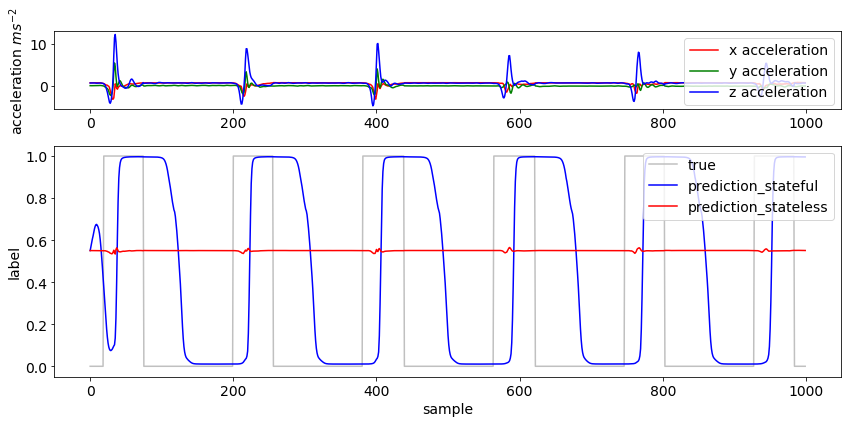

In [14]:
fig = plt.figure(figsize=(12, 6))
ax0 = plt.subplot2grid((10, 1), (0, 0), 3, 1)
ax1 = plt.subplot2grid((10, 1), (3, 0), 7, 1)

ax0.plot(accel_data[start:end, 0], 'r')
ax0.plot(accel_data[start:end, 1], 'g')
ax0.plot(accel_data[start:end, 2], 'b')
ax1.plot(accel_data[start:end, 3], 'silver')
ax1.plot(prediction_stateful[:, 1], 'b')
ax1.plot(prediction_stateless[:, 1], 'r')

ax0.set_ylabel(r'acceleration $ms^{-2}$')
ax1.set_xlabel('sample')
ax1.set_ylabel('label')

ax0.legend(['x acceleration','y acceleration','z acceleration'], loc=1)
ax1.legend(['true', 'prediction_stateful', 'prediction_stateless'], loc=1)

plt.tight_layout()
plt.show()